In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
import os

# Ignore all warnings
warnings.filterwarnings("ignore")

**Visualize RMSE on the testing period**

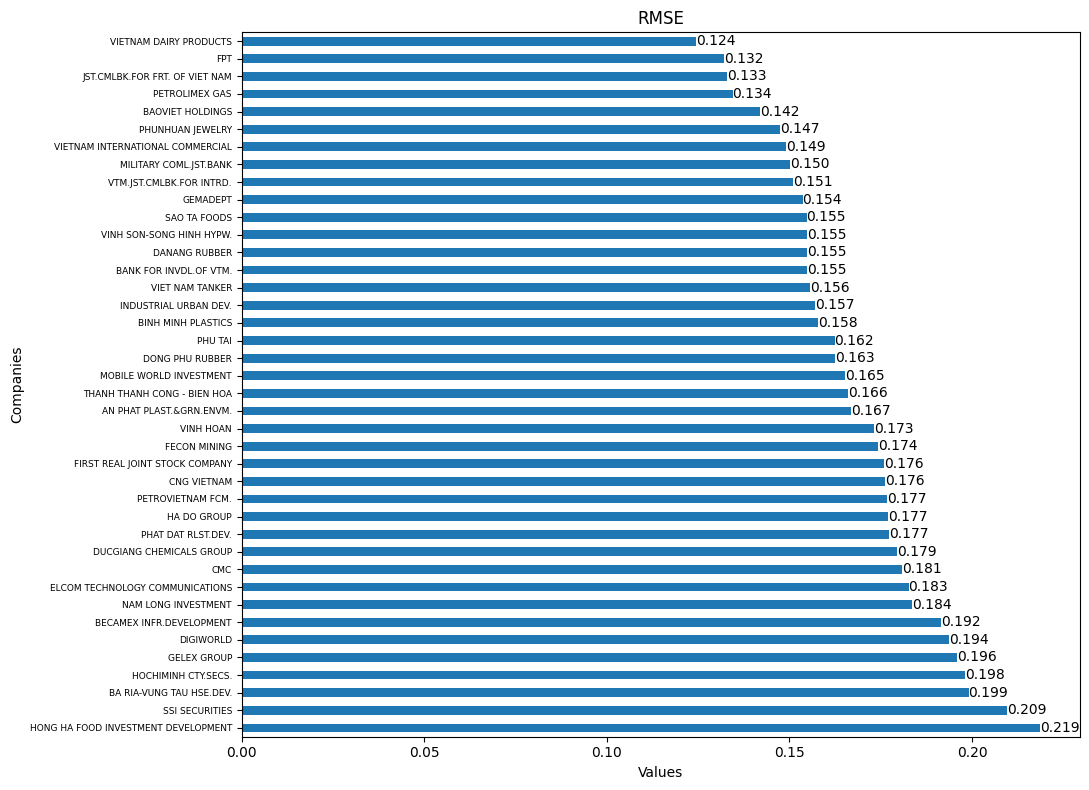

In [ ]:
performance = pd.read_csv("/content/drive/MyDrive/Team2/ML project output data/performance/performance.csv")
performance = performance.drop(columns="Unnamed: 0")


# Calculate the square root of the second row and sort values in descending order
sorted_performance = np.sqrt(performance.iloc[1]).sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(11, 8))
ax = sorted_performance.plot(kind='barh')

# Add values next to the bars
for index, value in enumerate(sorted_performance):
    plt.text(value, index, f'{value:.3f}', va='center')

# Adjust y-axis labels
plt.tick_params(axis='y', labelsize=6.5)

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Companies')
plt.title('RMSE')

# Show the plot
plt.tight_layout()
plt.show()

**Construct out portfolio, using predicted returns as weights for stocks within the portfolio**

In [ ]:
def list_files_only(directory):
    files = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path):
            files.append(item)
    return files

folder_path = '/content/drive/My Drive/Team2/ML project output data/'
files = list_files_only(folder_path)

df = {}

for file in files:
    file_path = os.path.join(folder_path, file)
    # Read the CSV file and store it in a dictionary with the filename as the key
    df[file[:-4]] = pd.read_csv(file_path)  # file[:-4] to remove '.csv' from the filename

alo = df

In [ ]:
date_eikon = pd.read_csv("/content/drive/MyDrive/Team2/ML project output data/performance/date_from_eikon.csv")

In [ ]:
actual_return = pd.DataFrame()
predicted_return = pd.DataFrame()
for i in df:
  actual_return[i] = df[i].actual_return
  predicted_return[i] = df[i].predicted_return

In [ ]:
# Function to Min-Max scale a row
def min_max_scale_row(row):
    min_val = row.min()
    max_val = row.max()
    return (row - min_val) / (max_val - min_val)

def scale_by_row_sum(row):
    row_sum = row.sum()
    return row / row_sum

def row_dot_product(row1, row2):
    return (row1 * row2).sum()

# Apply the Min-Max scaling to each row
new_A = predicted_return.apply(min_max_scale_row, axis=1)
new_A = new_A.apply(scale_by_row_sum, axis=1)

# Construct and calculate portfolio returns
portfolio = actual_return.apply(lambda row: row_dot_product(row, new_A.loc[row.name]), axis=1)
cumu_product_portfolio = (1 + portfolio).cumprod()
cumu_sum_portfolio = (portfolio).cumsum()

**Construct the performance of the equally-weighted, value-weighted and Vn-index**

In [ ]:
pip install --upgrade vnstock

In [ ]:
# Performance of the Vn-index
from vnstock import *
df = stock_historical_data("VNINDEX", "2021-12-31", "2024-05-26", "1D", 'index')
df["date"] = pd.to_datetime(df["time"])
df["return"] = df['close'].pct_change()
df["Vn_Index Cumu_product"] = (1 + df["return"]).cumprod()
df["Vn_Index Cumu"] = df["return"].cumsum()

In [ ]:
# Performance of the equally weighted portfolio
equal_weighted = actual_return.mean(axis=1)
cumu_product = (1 + equal_weighted).cumprod()
cumu_sum = (equal_weighted).cumsum()

In [ ]:
# Performance of the value weighted portfolio

comps = ["VTM.JST.CMLBK.FOR INTRD.", "VIETNAM INTERNATIONAL COMMERCIAL", "THANH THANH CONG - BIEN HOA", "PETROVIETNAM FCM.",
 "HA DO GROUP", "PHUNHUAN JEWELRY", "ELCOM TECHNOLOGY COMMUNICATIONS", "FECON MINING", "DONG PHU RUBBER", "CNG VIETNAM",
 "GELEX GROUP", "MOBILE WORLD INVESTMENT", "AN PHAT PLAST.&GRN.ENVM.", "VIETNAM DAIRY PRODUCTS", "DUCGIANG CHEMICALS GROUP",
 "DANANG RUBBER","FIRST REAL JOINT STOCK COMPANY","VINH SON-SONG HINH HYPW.","PETROLIMEX GAS", "INDUSTRIAL URBAN DEV.",
 "SSI SECURITIES", "PHAT DAT RLST.DEV.", "FPT", "JST.CMLBK.FOR FRT. OF VIET NAM", "NAM LONG INVESTMENT",
 "GEMADEPT", "BAOVIET HOLDINGS", "VIET NAM TANKER", "PHU TAI", "SAO TA FOODS","MILITARY COML.JST.BANK", "BANK FOR INVDL.OF VTM.", "HOCHIMINH CTY.SECS.",
 "BECAMEX INFR.DEVELOPMENT","DIGIWORLD","BA RIA-VUNG TAU HSE.DEV.", "VINH HOAN", "CMC", "HONG HA FOOD INVESTMENT DEVELOPMENT", "BINH MINH PLASTICS"]

li = [i + " - MARKET VALUE" for i in comps]

mcap = pd.read_excel("/content/drive/MyDrive/Team2/ML project output data/performance/RawData.xlsx", sheet_name = "Sheet2")
vw = mcap[["Date"] + li]

In [ ]:
vw["date"] = pd.to_datetime(vw.Date)
vw = vw[vw["date"].isin(date_eikon["date"])]
vw["sum"] = vw[li].sum(axis=1)
vw["return"] = vw["sum"].pct_change()
vw["VW cumu_product"] = (1 + vw["return"]).cumprod()
vw["VW cumu"] = (vw["return"]).cumsum()

In [ ]:
altogether = pd.DataFrame({'date': date_eikon["date"], 'cumu_product': cumu_product, "cumu_product_portfolio":cumu_product_portfolio})
altogether['date'] = pd.to_datetime(altogether['date'])
merged = pd.merge(altogether, df[["date", "Vn_Index Cumu_product"]], on="date", how = "left")
merged = pd.merge(merged, vw[["date", "VW cumu_product"]], on="date", how = "left")
merged = merged.set_index("date")
merged

,cumu_product,cumu_product_portfolio,Vn_Index Cumu_product,VW cumu_product
date,,,,
2022-01-04,1.016166,1.012046,1.018221,NaN
2022-01-05,1.018380,1.012742,1.016165,0.994091
2022-01-06,1.012511,1.007754,1.020217,0.995737
2022-01-07,1.004426,0.996246,1.020156,0.998236
2022-01-10,0.978727,0.971268,1.003624,0.984459
...,...,...,...,...
2024-05-20,0.999798,1.176039,0.852698,1.145880
2024-05-21,1.010540,1.186156,0.852404,1.150029
2024-05-22,1.009710,1.186097,0.845576,1.145479


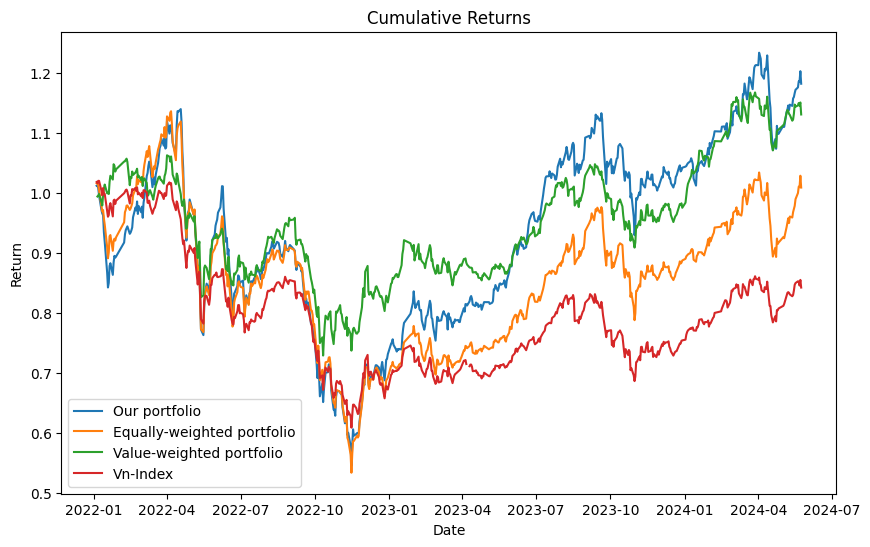

In [ ]:
plt.figure(figsize=(10, 6))
#plt.plot(cumu_sum, label='equal_weighted', marker='o')
plt.plot(merged.index, merged['cumu_product_portfolio'], label='Our portfolio')
plt.plot(merged.index, merged['cumu_product'], label='Equally-weighted portfolio')
plt.plot(merged.index, merged['VW cumu_product'], label='Value-weighted portfolio')
plt.plot(merged.index, merged["Vn_Index Cumu_product"], label='Vn-Index')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(False)
plt.legend()
plt.show()

In [ ]:
dailyreturns = pd.DataFrame({'date': date_eikon["date"], "portfolio": portfolio, "ew" : equal_weighted})
dailyreturns["date"] = pd.to_datetime(dailyreturns["date"])

dailyreturns = pd.merge(dailyreturns, vw[["date", "return"]], on="date", how = "left")
dailyreturns["vw"] = dailyreturns["return"]
dailyreturns = dailyreturns.drop(columns=["return"])

dailyreturns = pd.merge(dailyreturns, df[["date", "return"]], on="date", how = "left")
dailyreturns["Vn-Index"] = dailyreturns["return"]
dailyreturns = dailyreturns.drop(columns=["return"])

summary = dailyreturns.iloc[:,1:].describe().loc[["mean", "std"]]

In [ ]:
annual_rate = 0.03  # 3% annual interest rate
daily_rate = (1 + annual_rate) ** (1/365) - 1

summary.loc["Sharpe ratio (rf = 3%)"] = np.sqrt(252)*(summary.loc["mean"] - daily_rate)/summary.loc["std"]
summary

,portfolio,ew,vw,Vn-Index
mean,0.000456,0.000164,0.000302,-0.000206
std,0.018577,0.017173,0.013716,0.012912
Sharpe ratio (rf = 3%),0.320481,0.076550,0.256049,-0.353098
